In [141]:
import os
import string
import torch
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dill
from tqdm.notebook import tqdm

from cognitive_modeling.models.utility_models import u_pow, u_lin
from simulation.cpc_like import generate_data_cpc_like
from cognitive_modeling.cpc_like import fit_cpc_like
from discrepancy_modeling.discrepancy_modeling import DiscrepancyModel
from data.data import get

In [142]:
%config InlineBackend.figure_format = "retina"
sns.set_context("paper")

In [143]:
np.random.seed(123)
torch.manual_seed(123);

In [144]:
# Loading
df_dm = pd.read_pickle('bkp/dm_cpc.pkl')
df_dm.dm = df_dm.dm.apply(lambda x: dill.loads(x))
df_dm.index= df_dm.subject
df_dm.drop("subject", axis=1, inplace=True)
df_dm

,dm,h,u,tau,theta,n_samples,n_inducing_points,learn_inducing_locations,jitter
subject,,,,,,,,,
11303,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,669.895791,1.151018,100,50,False,1.000000e-07
10113,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,27.458567,3.093270,100,50,False,1.000000e-07
10316,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,55.305147,1.327157,100,50,False,1.000000e-07
11603,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,13.170793,0.494840,100,50,False,1.000000e-07
11020,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,16670.197828,1.003339,100,50,False,1.000000e-07
...,...,...,...,...,...,...,...,...,...
11002,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,15713.384617,1.002052,100,50,False,1.000000e-07
11327,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,135.016072,0.769305,100,50,False,1.000000e-07
10104,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,6.363320,0.194913,100,50,False,1.000000e-07


In [145]:
for s in df_dm.index:
    
    test_x = torch.linspace(0, 1, 1000)
    
    dm = df_dm.loc[s, "dm"]
    
    m_pred, f_pred = dm.pred(test_x) 
    
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)
    
    # Compute correction
    corr = f_mean - m_pred 
    corr_lower = lower - m_pred
    corr_upper = upper - m_pred
    
    df_dm.loc[s, "disc_mean"] = np.power(f_mean - m_pred, 2).mean()
    df_dm.loc[s, "disc_sd"] = np.mean(corr_upper - corr_lower)

In [146]:
f"{df_dm.disc_mean.min()}, {df_dm.disc_mean.max()}"

'1.0454919265392992e-12, 0.2959209680557251'

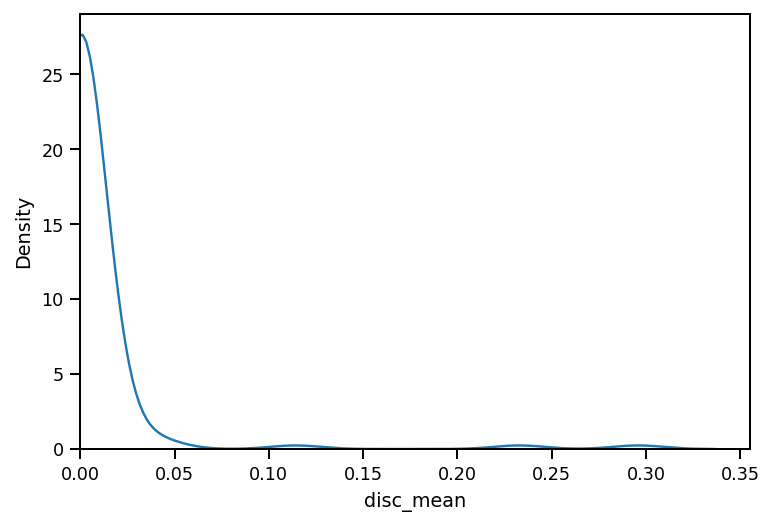

In [147]:
fig, ax = plt.subplots()
sns.kdeplot(df_dm.disc_mean, ax=ax)
ax.set_xlim(0,None);

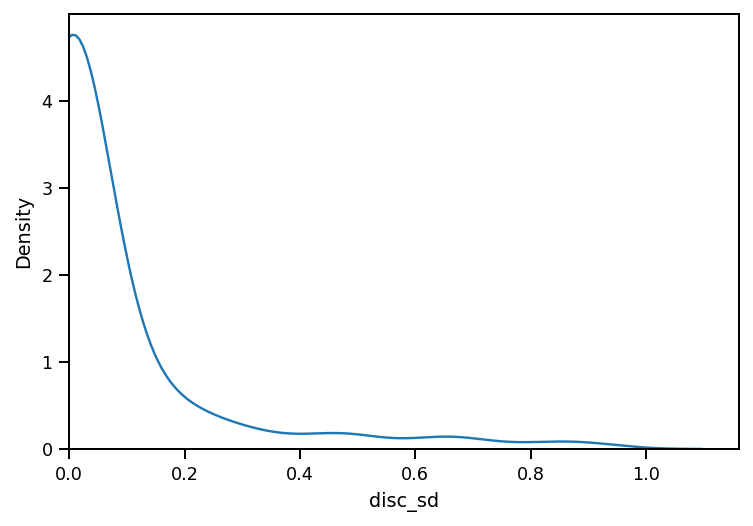

In [148]:
fig, ax = plt.subplots()
sns.kdeplot(df_dm.disc_sd, ax=ax)
ax.set_xlim(0,None);

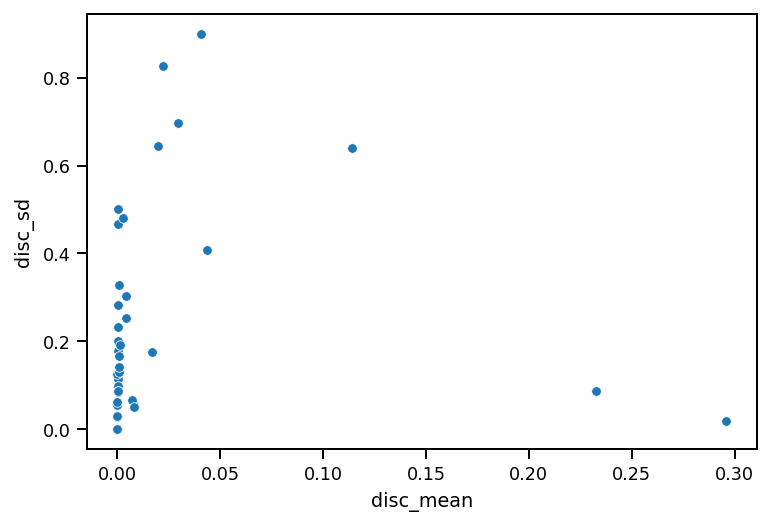

In [149]:
sns.scatterplot(x=df_dm.disc_mean, y=df_dm.disc_sd);

In [150]:
scipy.stats.spearmanr(df_dm.disc_mean, df_dm.disc_sd)

SpearmanrResult(correlation=0.7908448540706605, pvalue=5.343643850577015e-28)

In [151]:
dm_low_conf = df_dm.iloc[df_dm.disc_sd.argmax()]["dm"]

In [152]:
bound_conf = np.percentile(df_dm.disc_sd, [90, ], axis=0)[0]  # 95
bound_mean = np.percentile(df_dm.disc_mean, [90, ], axis=0)[0]  # 95
print(f"bound conf {bound_conf}, bound mean {bound_mean}")

bound conf 0.24522800404426603, bound mean 0.004282578360289338


In [153]:
df_select = df_dm.loc[(df_dm.disc_sd < bound_conf) & (df_dm.disc_mean < bound_mean), ]

idx_low = df_select.disc_mean.argmin()
dm_low_corr = df_select.iloc[idx_low]["dm"]

idx_high = df_select.disc_mean.argmax()
dm_high_corr = df_select.iloc[idx_high]["dm"]

idx_medium = np.argmin(np.abs(df_select.disc_mean - df_select.disc_mean.mean()))
dm_medium_corr = df_select.iloc[idx_medium]["dm"]

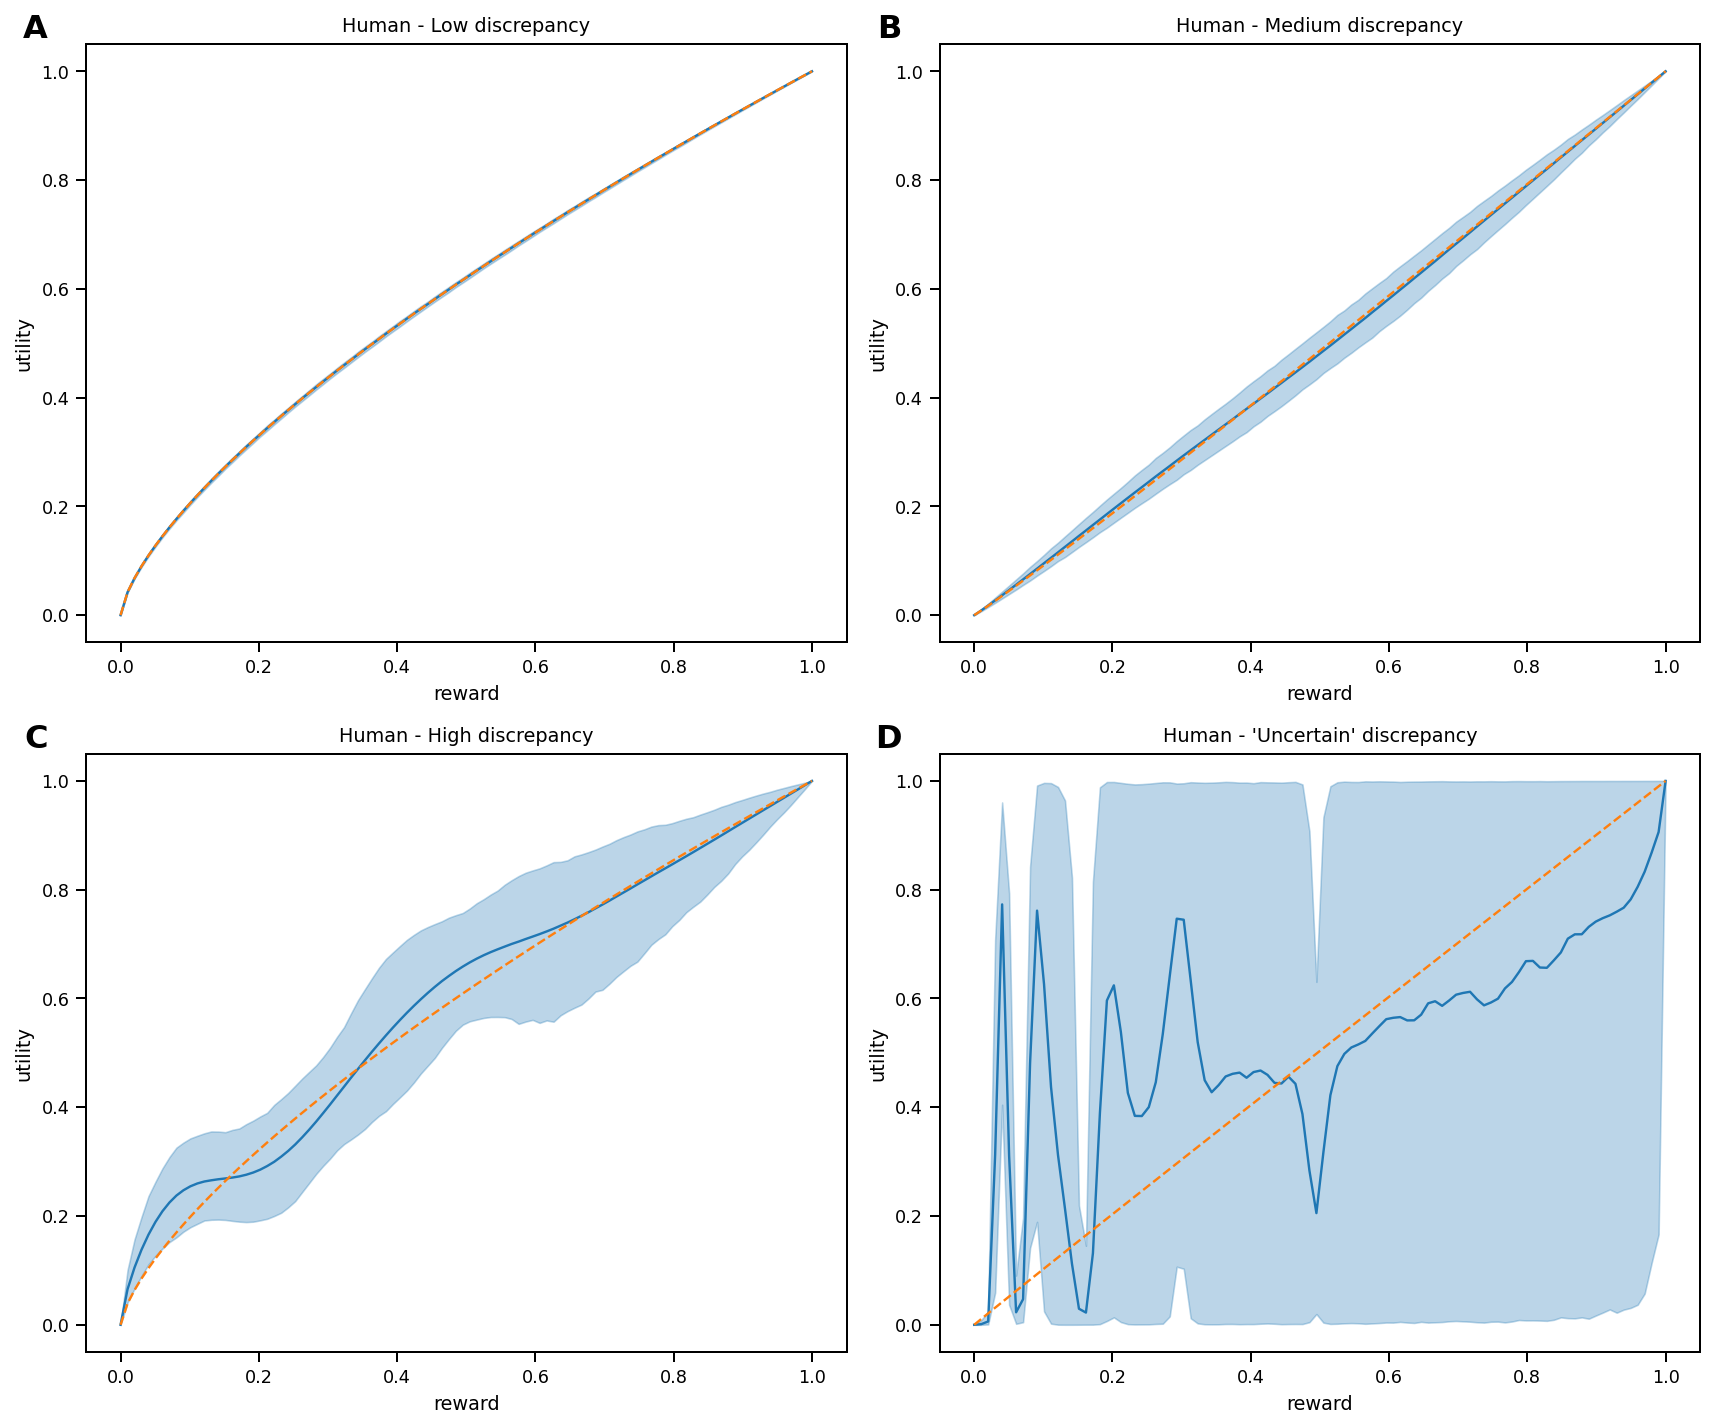

In [154]:
fig, axes = plt.subplots(figsize=(12, 10), nrows=2, ncols=2)

axes = (ax for ax in axes.flatten())

letters = (letter for letter in string.ascii_uppercase)

for dm, dm_name in ((dm_low_corr, "Human - Low discrepancy"), 
                    (dm_medium_corr, "Human - Medium discrepancy"), 
                    (dm_high_corr, "Human - High discrepancy"), 
                    (dm_low_conf, "Human - 'Uncertain' discrepancy")):
    
    ax = next(axes)
    ax.set_title(dm_name)

    fill_alpha = 0.3

    test_x = torch.linspace(0, 1, 100)
    m_pred, f_pred = dm.pred(test_x)

    test_x = test_x.numpy()
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)

    ax.text(-0.05, 1.05, next(letters), transform=ax.transAxes, fontsize=16, 
            fontweight='bold', va='top', ha='right')

    # GP confidence
    h_conf = ax.fill_between(test_x, upper, lower, color='C0', alpha=fill_alpha, label="Model + correction - Confidence")

    # GP mean
    h_mean, = ax.plot(test_x, f_mean, label="Model + correction - Mean")

    # Model
    h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")

    ax.set_xlabel("reward")
    ax.set_ylabel("utility")


fig.tight_layout()

os.makedirs("fig", exist_ok=True)
plt.savefig("fig/risk_cpc.pdf", bbox_inches='tight')

- Add justification EU: easy to understand by large audience, can be easily generalized to CPT? BEAST and so on
- Add plot of distribution
- Add more examples

- discussion
- multivariate output
- 